In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Input, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import h5py
import matplotlib.pyplot as plt
import warnings
import json
import gzip
import os
import sys
import tarfile
import glob
import random
import shutil
import seaborn as sns
from PIL import Image, ImageDraw
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
# if importing directly from the url

# urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/train.tar.gz", "../Data/train.tar.gz")
# urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/test.tar.gz", "../Data/test.tar.gz")
# urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/extra.tar.gz", "../Data/extra.tar.gz")

In [2]:
data = glob.glob('../RawData/csv/*')

In [3]:
data

['../RawData/csv\\extra_images.csv',
 '../RawData/csv\\extra_images_2.csv',
 '../RawData/csv\\extra_labels.csv',
 '../RawData/csv\\extra_labels_2.csv',
 '../RawData/csv\\test_images.csv',
 '../RawData/csv\\test_images_2.csv',
 '../RawData/csv\\test_labels.csv',
 '../RawData/csv\\test_labels_2.csv',
 '../RawData/csv\\train_images.csv',
 '../RawData/csv\\train_images_2.csv',
 '../RawData/csv\\train_labels.csv',
 '../RawData/csv\\train_labels_2.csv']

In [4]:
train_images = pd.read_csv('../RawData/csv/train_images.csv')
train_labels = pd.read_csv('../RawData/csv/train_labels.csv')
test_images = pd.read_csv('../RawData/csv/test_images.csv')
test_labels = pd.read_csv('../RawData/csv/test_labels.csv')
extra_images = pd.read_csv('../RawData/csv/extra_images.csv')
extra_labels = pd.read_csv('../RawData/csv/extra_labels.csv')

In [ ]:
train_images.head()

In [ ]:
train_labels.head()

In [ ]:
type(train_images)

In [5]:
train_images = np.array(train_images.iloc[:,1:].astype('float32'))
train_labels = np.array(train_labels.iloc[:,1:].astype('int16'))

test_images = np.array(test_images.iloc[:,1:].astype('float32'))
test_labels = np.array(test_labels.iloc[:,1:].astype('int16'))

extra_images = np.array(extra_images.iloc[:,1:].astype('float32'))
extra_labels = np.array(extra_labels.iloc[:,1:].astype('int16'))

In [ ]:
type(train_labels)

Label:  [10 10 10  3  6]


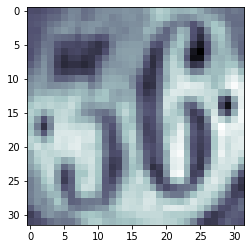

In [6]:
print('Label: ', train_labels[4])
plt.imshow(train_images[4].reshape(32,32), cmap=plt.cm.bone)
plt.show()

In [7]:
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])    
    for i in range(n):
        data_cat[:, i] = to_categorical(data[:, i], num_classes=11)        
    return data_cat

In [8]:
x_train = np.concatenate((train_images.reshape(-1, 32, 32, 1),
                             test_images.reshape(-1, 32, 32, 1)),
                            axis=0)
y_train = np.concatenate((digit_to_categorical(train_labels),
                             digit_to_categorical(test_labels)),
                            axis=0)

x_valid = extra_images.reshape(-1, 32, 32, 1)
y_valid = digit_to_categorical(extra_labels)

n = int(len(x_valid)/2)
x_test, y_test = x_valid[:n], y_valid[:n]
x_valid, y_valid = x_valid[n:], y_valid[n:]

x_train.shape, x_test.shape, x_valid.shape, \
y_train.shape, y_test.shape, y_valid.shape

((19000, 32, 32, 1),
 (6500, 32, 32, 1),
 (6500, 32, 32, 1),
 (19000, 5, 11),
 (6500, 5, 11),
 (6500, 5, 11))

In [9]:
y_train_list = [y_train[:, i] for i in range(5)]
y_test_list = [y_test[:, i] for i in range(5)]
y_valid_list = [y_valid[:, i] for i in range(5)]

In [10]:
def cnn_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
        
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)       
    x = Conv2D(64, (3, 3), activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)    
    x = BatchNormalization()(x)
              
    x = Flatten()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(11, activation='softmax')(x)
    y2 = Dense(11, activation='softmax')(x)
    y3 = Dense(11, activation='softmax')(x)
    y4 = Dense(11, activation='softmax')(x)
    y5 = Dense(11, activation='softmax')(x)
    model = Model(inputs=model_input, outputs=[y1,y2,y3,y4,y5])
    
    optimizer = Adam(learning_rate=0.001)#, decay=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
cnn_model = cnn_model()

In [13]:
schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 * 10**(epoch / 10),4)

In [14]:
cnn_history = cnn_model.fit(x_train, y_train_list, 
                            validation_data=(x_valid, y_valid_list), 
                            epochs=10,batch_size=128, callbacks=schedule, verbose=0)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00012589254117941674.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00015848931924611136.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00019952623149688796.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000251188643150958.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.000316227766016838.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.00039810717055349724.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0005011872336272722.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0006309573444801934.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0007943282347242816.


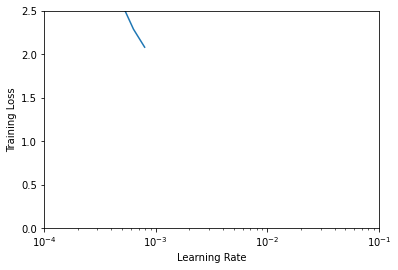

In [18]:
plt.semilogx(cnn_history.history['lr'], cnn_history.history['loss'])
plt.axis([0.0001, 0.1, 0, 2.5])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

In [16]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   9248        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [17]:
print(cnn_history.history.keys())

dict_keys(['loss', 'dense_1_loss', 'dense_2_loss', 'dense_3_loss', 'dense_4_loss', 'dense_5_loss', 'dense_1_accuracy', 'dense_2_accuracy', 'dense_3_accuracy', 'dense_4_accuracy', 'dense_5_accuracy', 'val_loss', 'val_dense_1_loss', 'val_dense_2_loss', 'val_dense_3_loss', 'val_dense_4_loss', 'val_dense_5_loss', 'val_dense_1_accuracy', 'val_dense_2_accuracy', 'val_dense_3_accuracy', 'val_dense_4_accuracy', 'val_dense_5_accuracy', 'lr'])


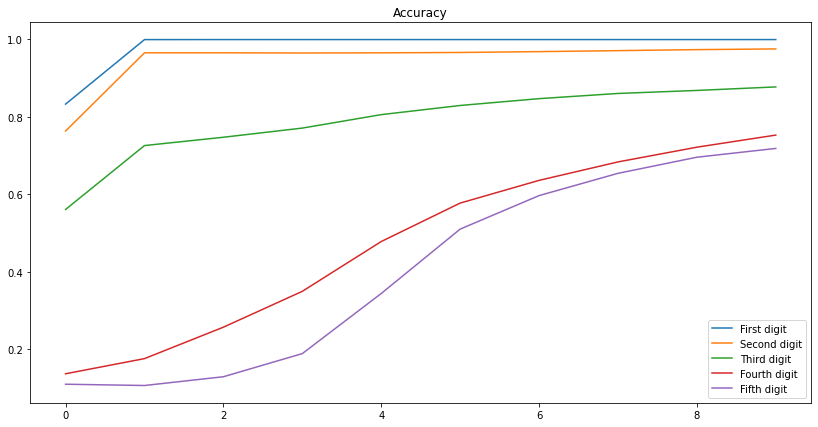

In [21]:
plt.figure(figsize=(14, 7))

plt.plot(cnn_history.history['dense_1_accuracy'], label = 'First digit')
plt.plot(cnn_history.history['dense_2_accuracy'], label = 'Second digit')
plt.plot(cnn_history.history['dense_3_accuracy'], label = 'Third digit')
plt.plot(cnn_history.history['dense_4_accuracy'], label = 'Fourth digit')
plt.plot(cnn_history.history['dense_5_accuracy'], label = 'Fifth digit')

plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
print(cnn_history.history.keys())

In [ ]:
cnn_model().summary()